In [227]:
# importing libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'webster-data445-bucket'
bucket = s3.Bucket(bucket_name)

# defining the train csv file
file_key = 'fraud_train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
train = train.dropna()
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [228]:
# defining the test csv file
file_key = 'fraud_test.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
test = pd.read_csv(file_content_stream, sep = '|')
# dropping missing values
test = test.dropna()
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [229]:
# checking number of rows and observations
rows = len(train.axes[0])
cols = len(train.axes[1])
print('Train:', rows, cols)

rows_test = len(test.axes[0])
cols_test = len(test.axes[1])
print('Test:', rows_test, cols_test)

# Our train dataset has 1879 observations and 10 variables
# Our test dataset has 498121 observations and 10 variables

Train: 1879 10
Test: 498121 9


Text(0.5, 1.0, 'Distirbution of Trust Levels')

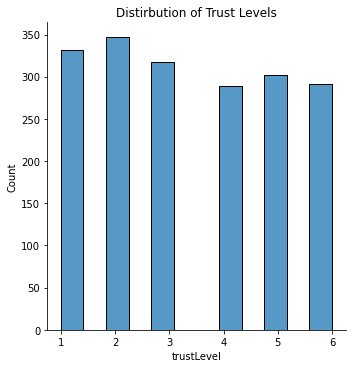

In [230]:
# distribution plot of trust levels
dist_trust = sns.displot(train['trustLevel'])
plt.title('Distirbution of Trust Levels')

## We can see that our trust levels are slightly right skewed

<AxesSubplot:>

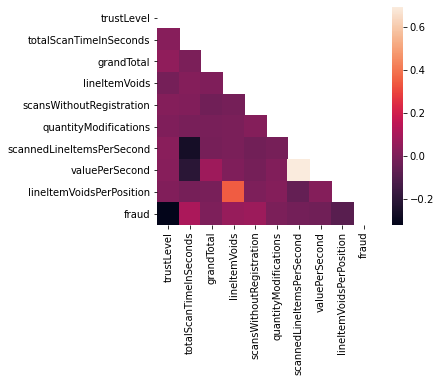

In [231]:
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, square = True)

# train.corr().fraud

## We can see high correlations between fraud and trust level, totalScanTimeInSeconds, scansWithoutRegistration, lineItemVoids, and valuePerSecond.
## I will use these to create my models

In [299]:
X = train[['trustLevel', 'totalScanTimeInSeconds', 'scansWithoutRegistration', 'lineItemVoids', 'valuePerSecond']]
Y = train['fraud']

# splitting into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [300]:
# building the random forest
RF1 = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

# predicting on test
RF_pred = RF1.predict_proba(X_test)[:, 1]

<function matplotlib.pyplot.show(close=None, block=None)>

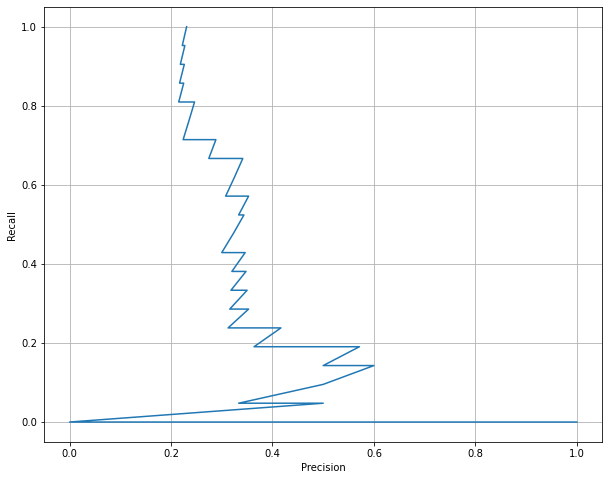

In [301]:
# computing ROC curve
precision, recall, threshold = precision_recall_curve(Y_test, RF_pred)

# creating a dataframe with unpacked roc values
cutoffs = pd.DataFrame({'Precision' : precision[:-1], 'Recall' : recall[:-1], 'Cutoff' : threshold}) ## precision and recall are +1, so have to remove the last observation

# visualizing
plt.figure(figsize = (10, 8))
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.show

In [302]:
# finding the optimal cutoff
cutoffs['Recall_minus_1'] = cutoffs['Recall'] - 1

# finding euclidean distance
cutoffs['Euclidian_dist'] = np.sqrt(cutoffs['Precision']**2 + cutoffs['Recall_minus_1']**2)
cutoffs = cutoffs.sort_values(by = 'Euclidian_dist').reset_index(drop = True)

# changing likelihoods to labels
RF_pred = np.where(RF_pred < cutoffs['Euclidian_dist'][0], 0, 1)

# printing classification report
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       355
           1       0.33      0.57      0.42        21

    accuracy                           0.91       376
   macro avg       0.65      0.75      0.69       376
weighted avg       0.94      0.91      0.92       376



In [303]:
# building the ada boost classifier
AB1 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01).fit(X_train, Y_train)

# predicting on test
AB_pred = AB1.predict_proba(X_test)[:, 1]

<function matplotlib.pyplot.show(close=None, block=None)>

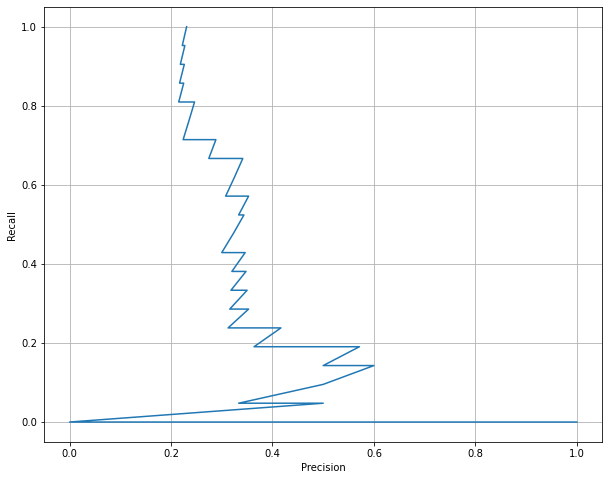

In [304]:
# computing ROC curve
precision2, recall2, threshold2 = precision_recall_curve(Y_test, AB_pred)

# creating a dataframe with unpacked roc values
cutoffs2 = pd.DataFrame({'Precision' : precision2[:-1], 'Recall' : recall2[:-1], 'Cutoff' : threshold2})

# visualizing
plt.figure(figsize = (10, 8))
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.show

In [305]:
# finding the optimal cutoff
cutoffs2['Recall_minus_1'] = cutoffs2['Recall'] - 1

# finding euclidean distance
cutoffs2['Euclidian_dist'] = np.sqrt(cutoffs2['Precision']**2 + cutoffs2['Recall_minus_1']**2)
cutoffs2 = cutoffs2.sort_values(by = 'Euclidian_dist').reset_index(drop = True)

# changing likelihoods to labels
AB_pred = np.where(AB_pred < cutoffs2['Euclidian_dist'][0], 0, 1)

# printing classification report
print(classification_report(Y_test, AB_pred))

              precision    recall  f1-score   support

           0       1.00      0.66      0.80       355
           1       0.14      0.95      0.25        21

    accuracy                           0.68       376
   macro avg       0.57      0.81      0.52       376
weighted avg       0.95      0.68      0.77       376



In [306]:
## Based on the results, I would choose the Random Forest model. This is because it only does slightly worse at predicting '0', but does a much better job
## at prediction '1.'